In [15]:
from os import listdir
from os.path import isfile, join

import numpy as np
from CSIKit.reader import get_reader
from CSIKit.util import csitools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
## Creating dataset without service subcarriers
### Data downloading

In [16]:
def getCsiMatrFromPcap(fileName: str, CsiFilesFolder: str) -> pd.DataFrame:
    pcapFilePath = join(CsiFilesFolder, fileName)
    my_reader = get_reader(pcapFilePath)
    csi_data = my_reader.read_file(pcapFilePath, scaled=False)
    csi_matrix, no_frames, no_subcarriers = csitools.get_CSI(csi_data, metric="amplitude")
    csi_matrix = csi_matrix[:, :, 0, 0]
    csi_matrix = pd.DataFrame(csi_matrix)
    return csi_matrix

def getCsiMatrFromCsv(fileName: str, CsiFilesFolder: str) -> pd.DataFrame:
    if ".csv" not in fileName:
        if "." not in fileName:
            fileName += ".csv"
        else:
            # .pcap
            fileName = fileName[:-5] + ".csv"

    csvFilePath = join(CsiFilesFolder, fileName)
    return pd.read_csv(csvFilePath)

In [17]:
csi_data_folder = "CSICapturedFiles/csi_data1"
csiFiles = [fileName for fileName in listdir(csi_data_folder) if isfile(join(csi_data_folder, fileName))]
csi_dict: {str: pd.DataFrame} = dict()
for fileName in csiFiles:
    csi_matrix = getCsiMatrFromPcap(fileName, csi_data_folder)
    # csi_matrix.head(2)
    csi_dict[fileName] = csi_matrix

# csi_dict
# NEXBeamformReader.read_bfee

In [18]:
csi_matrix

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,22.576786,18.129134,6.020600,13.010300,12.041200,16.127839,50.059437,53.307262,55.036123,56.830795,...,47.400625,51.664952,54.580211,56.666724,57.771802,0.000000,20.644580,21.958997,16.989700,9.542425
1,12.041200,18.129134,10.000000,3.010300,13.010300,12.552725,50.140541,53.264444,55.054674,56.965530,...,47.367788,51.095718,54.220396,56.482556,57.589058,18.573325,16.901961,21.139434,14.149733,21.731863
2,17.853298,18.129134,13.010300,6.989700,12.304489,23.443923,49.730585,53.108908,55.399037,57.114605,...,47.229710,51.168733,54.295213,56.363083,57.744994,6.989700,15.051500,20.969100,12.041200,19.493900
3,14.623980,18.129134,19.030900,15.051500,9.542425,12.304489,48.820974,52.314135,55.368109,57.218246,...,48.567832,52.232830,54.797653,56.377988,57.491687,15.563025,20.170333,19.867717,17.242759,14.149733
4,16.532125,18.129134,6.020600,15.314789,12.552725,19.138139,49.979802,52.896647,54.715455,56.899203,...,47.261075,51.316988,54.464750,56.635596,57.641731,16.532125,16.127839,18.129134,13.979400,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,19.294189,18.129134,16.020600,3.010300,24.712917,14.149733,49.376483,53.153699,55.786129,57.415652,...,48.816186,52.139346,54.622902,56.136156,57.390610,13.010300,18.633229,13.010300,14.149733,14.149733
334,14.149733,18.129134,-inf,11.139434,16.532125,11.139434,49.746821,52.985321,55.727601,57.263294,...,48.832070,52.116571,54.684950,56.086127,57.344942,20.530784,13.979400,20.043214,16.989700,17.634280
335,18.573325,18.129134,6.989700,19.294189,9.030900,16.020600,16.127839,9.542425,16.020600,14.149733,...,38.406079,44.924251,35.108130,41.364986,43.879768,41.960379,45.700991,14.623980,13.979400,16.989700
336,21.731863,18.129134,18.325089,6.989700,10.000000,19.294189,50.291970,53.029389,55.518524,57.108448,...,47.882886,51.953377,54.450263,56.387308,57.464232,19.867717,15.314789,21.731863,22.855573,13.979400


### service subcarriers extracting

I wanted
to go through all files and all packets in each file.

Then if subcarrier have value, that is greater than 75%-th quantile of values in packet, it gets one vote.

Number of all votes equals sum of number of packets in each file.

If subcarrier has more than 70% of all votes, it is a service subcarrier.

But mentor said to google indexes of service subcarriers

In [19]:
# service subcarriers
trashSubcarriers = np.array([0, 1] + list(range(123, 134))+ [255])

In [20]:
print("service subcarriers:", trashSubcarriers)

service subcarriers: [  0   1 123 124 125 126 127 128 129 130 131 132 133 255]


In [21]:
for fileName in csi_dict:
    csi_dict[fileName] = csi_dict[fileName].drop(columns=trashSubcarriers)

##### file with service subcarriers, one packet plot

Text(0, 0.5, 'amplitude')

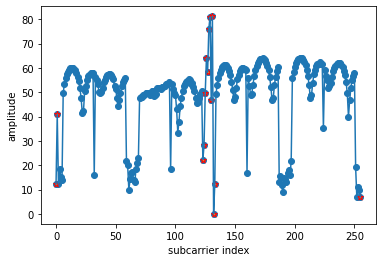

In [22]:
fileName = list(csi_dict.keys())[0]
csi_matrix = getCsiMatrFromPcap(fileName, csi_data_folder)
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)

plt.scatter(trashSubcarriers, packet.values[trashSubcarriers], edgecolors="red", marker="*")
plt.xlabel("subcarrier index")
plt.ylabel("amplitude")

Text(33.0, 0.5, 'subcarrier index')

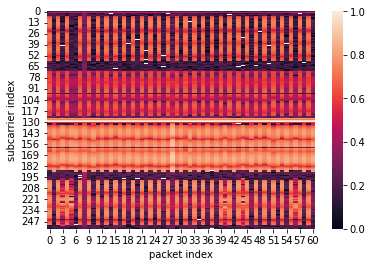

In [23]:
maxVal = csi_matrix.max().max()
csi_matrix = csi_matrix / maxVal

sns.heatmap(csi_matrix.T, vmin=0, vmax=csi_matrix.values.max())
plt.xlabel("packet index")
plt.ylabel("subcarrier index")

##### file without service subcarriers, one packet plot

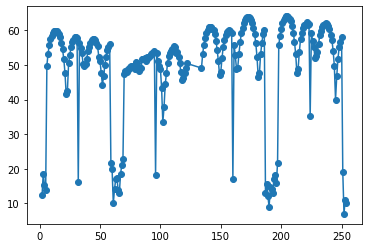

In [24]:
csi_matrix = csi_dict[fileName]
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)

Text(33.0, 0.5, 'subcarrier index')

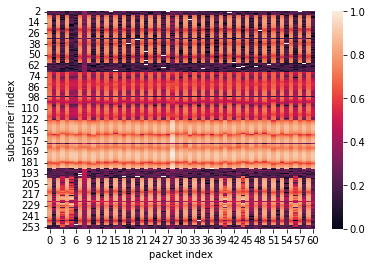

In [25]:
maxVal = csi_matrix.max().max()
csi_matrix = csi_matrix / maxVal

sns.heatmap(csi_matrix.T, vmin=0, vmax=csi_matrix.values.max())
plt.xlabel("packet index")
plt.ylabel("subcarrier index")

### uploading csi amplitude matrices into csv files

In [26]:
csi_cvs_folder = "dataset1"
for fileName in csi_dict:
    csvFileName = fileName[:-5] + ".csv"
    csi_dict[fileName].to_csv(join(csi_cvs_folder, csvFileName), index=False)

##### csi matrix from csv file

,2,3,4,5,6,7,8,9,10,11,...,245,246,247,248,249,250,251,252,253,254
0,6.020600,13.010300,12.041200,16.127839,50.059437,53.307262,55.036123,56.830795,58.072820,59.104841,...,45.214781,47.400625,51.664952,54.580211,56.666724,57.771802,0.000000,20.644580,21.958997,16.989700
1,10.000000,3.010300,13.010300,12.552725,50.140541,53.264444,55.054674,56.965530,58.297751,59.250773,...,45.530330,47.367788,51.095718,54.220396,56.482556,57.589058,18.573325,16.901961,21.139434,14.149733
2,13.010300,6.989700,12.304489,23.443923,49.730585,53.108908,55.399037,57.114605,58.478052,59.322231,...,45.453566,47.229710,51.168733,54.295213,56.363083,57.744994,6.989700,15.051500,20.969100,12.041200
3,19.030900,15.051500,9.542425,12.304489,48.820974,52.314135,55.368109,57.218246,58.414202,59.157216,...,44.082400,48.567832,52.232830,54.797653,56.377988,57.491687,15.563025,20.170333,19.867717,17.242759
4,6.020600,15.314789,12.552725,19.138139,49.979802,52.896647,54.715455,56.899203,58.141463,59.230377,...,46.207605,47.261075,51.316988,54.464750,56.635596,57.641731,16.532125,16.127839,18.129134,13.979400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,16.020600,3.010300,24.712917,14.149733,49.376483,53.153699,55.786129,57.415652,58.574724,59.356302,...,44.333057,48.816186,52.139346,54.622902,56.136156,57.390610,13.010300,18.633229,13.010300,14.149733
334,-inf,11.139434,16.532125,11.139434,49.746821,52.985321,55.727601,57.263294,58.547929,59.218206,...,44.386531,48.832070,52.116571,54.684950,56.086127,57.344942,20.530784,13.979400,20.043214,16.989700
335,6.989700,19.294189,9.030900,16.020600,16.127839,9.542425,16.020600,14.149733,18.573325,0.000000,...,18.692317,38.406079,44.924251,35.108130,41.364986,43.879768,41.960379,45.700991,14.623980,13.979400
336,18.325089,6.989700,10.000000,19.294189,50.291970,53.029389,55.518524,57.108448,58.444902,59.236486,...,45.062344,47.882886,51.953377,54.450263,56.387308,57.464232,19.867717,15.314789,21.731863,22.855573


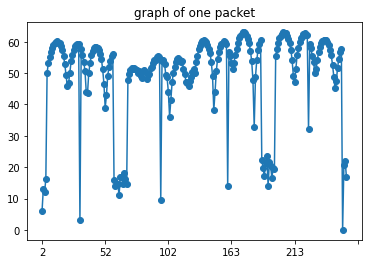

In [27]:
csi_matrix = getCsiMatrFromCsv(fileName, csi_cvs_folder)
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)
plt.title("graph of one packet")

csi_matrix

##### csi matrix from csi_dict

,2,3,4,5,6,7,8,9,10,11,...,245,246,247,248,249,250,251,252,253,254
0,6.020600,13.010300,12.041200,16.127839,50.059437,53.307262,55.036123,56.830795,58.072820,59.104841,...,45.214781,47.400625,51.664952,54.580211,56.666724,57.771802,0.000000,20.644580,21.958997,16.989700
1,10.000000,3.010300,13.010300,12.552725,50.140541,53.264444,55.054674,56.965530,58.297751,59.250773,...,45.530330,47.367788,51.095718,54.220396,56.482556,57.589058,18.573325,16.901961,21.139434,14.149733
2,13.010300,6.989700,12.304489,23.443923,49.730585,53.108908,55.399037,57.114605,58.478052,59.322231,...,45.453566,47.229710,51.168733,54.295213,56.363083,57.744994,6.989700,15.051500,20.969100,12.041200
3,19.030900,15.051500,9.542425,12.304489,48.820974,52.314135,55.368109,57.218246,58.414202,59.157216,...,44.082400,48.567832,52.232830,54.797653,56.377988,57.491687,15.563025,20.170333,19.867717,17.242759
4,6.020600,15.314789,12.552725,19.138139,49.979802,52.896647,54.715455,56.899203,58.141463,59.230377,...,46.207605,47.261075,51.316988,54.464750,56.635596,57.641731,16.532125,16.127839,18.129134,13.979400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,16.020600,3.010300,24.712917,14.149733,49.376483,53.153699,55.786129,57.415652,58.574724,59.356302,...,44.333057,48.816186,52.139346,54.622902,56.136156,57.390610,13.010300,18.633229,13.010300,14.149733
334,-inf,11.139434,16.532125,11.139434,49.746821,52.985321,55.727601,57.263294,58.547929,59.218206,...,44.386531,48.832070,52.116571,54.684950,56.086127,57.344942,20.530784,13.979400,20.043214,16.989700
335,6.989700,19.294189,9.030900,16.020600,16.127839,9.542425,16.020600,14.149733,18.573325,0.000000,...,18.692317,38.406079,44.924251,35.108130,41.364986,43.879768,41.960379,45.700991,14.623980,13.979400
336,18.325089,6.989700,10.000000,19.294189,50.291970,53.029389,55.518524,57.108448,58.444902,59.236486,...,45.062344,47.882886,51.953377,54.450263,56.387308,57.464232,19.867717,15.314789,21.731863,22.855573


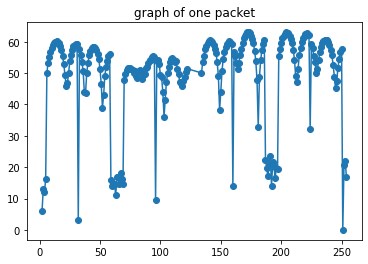

In [28]:
csi_matrix = csi_dict[fileName]
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)
plt.title("graph of one packet")
csi_matrix